# Вакансия Big Data МТС

Датасет – отток абонентов в телекоме. 

Целевая переменная – churn (индикатор оттока).

Нужно построить модель, предсказывающую отток, оценить качество этой модели и гипотетические перспективы использования этой модели в реальном бизнес процессе.

Дополнительной информации об этом датасете нет, названия столбцов в большинстве случаев достаточно хорошо отражают их содержание.

In [8]:
# library import
import warnings 
import numpy as np 
import pandas as pd
import seaborn as se  
import matplotlib.pyplot as plt 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,plot_confusion_matrix
warnings.filterwarnings('ignore')
import lifelines as lf

from translate import Translator
translator = Translator(from_lang="english",to_lang="russian")

%matplotlib inline

In [9]:
# read the file and print the first line
telco = pd.read_csv('telco-customer-churn.csv')

telco.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


In [3]:
# descriptive statistics
telco.describe()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
count,20468.000000,20468.000000,20468.000000,20468.000000,2.046800e+04,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.000000
mean,45.334327,124446.818253,0.035021,0.015239,4.220203e+09,4757.953342,59.630252,1.499169,3.489252,49.366816,248.792603,249.740522,126.656879,0.496528,3521.696306,721.521057,0.091020,2015.0,1.611687
std,19.624577,72129.392001,0.022996,0.011213,3.365196e+08,2751.070062,34.652681,1.119153,2.289740,28.874138,144.247247,144.198066,70.367800,0.288220,1959.642260,225.677596,0.287645,0.0,0.621895
min,12.000000,4.000000,0.000000,0.000000,1.022955e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,1.000000
25%,28.000000,61898.000000,0.010000,0.010000,4.251031e+09,2372.750000,29.000000,0.000000,1.000000,24.000000,124.000000,126.000000,66.000000,0.250000,2047.750000,582.000000,0.000000,2015.0,1.000000
50%,45.000000,123689.500000,0.040000,0.020000,4.251054e+09,4754.000000,60.000000,2.000000,3.000000,49.000000,249.000000,249.000000,122.000000,0.500000,3365.000000,721.000000,0.000000,2015.0,2.000000
75%,62.000000,187065.250000,0.060000,0.030000,4.251077e+09,7141.250000,90.000000,3.000000,5.000000,74.000000,373.000000,374.000000,191.000000,0.750000,4786.250000,862.000000,0.000000,2015.0,2.000000
max,79.000000,249987.000000,0.070000,0.030000,4.251100e+09,9525.000000,119.000000,3.000000,7.000000,99.000000,499.000000,499.000000,249.000000,0.990000,16662.000000,1439.000000,1.000000,2015.0,3.000000


In [10]:
telco.columns

Index(['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum',
       'customerid', 'customersuspended', 'education', 'gender', 'homeowner',
       'maritalstatus', 'monthlybilledamount', 'noadditionallines',
       'numberofcomplaints', 'numberofmonthunpaid',
       'numdayscontractequipmentplanexpiring', 'occupation', 'penaltytoswitch',
       'state', 'totalminsusedinlastmonth', 'unpaidbalance',
       'usesinternetservice', 'usesvoiceservice',
       'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration',
       'churn', 'year', 'month'],
      dtype='object')

In [4]:
# translate columns 
[(x, translator.translate(x)) for x in telco.columns]

[('age', 'возраст'),
 ('annualincome', 'годовой доход'),
 ('calldroprate', 'каллдропрат'),
 ('callfailurerate', 'callfailurerate'),
 ('callingnum', 'звонящий'),
 ('customerid', 'CustomerID'),
 ('customersuspended', 'клиенты приостановлены'),
 ('education', 'образование'),
 ('gender', 'пол'),
 ('homeowner', 'владелец дома'),
 ('maritalstatus', 'MaritalStatus'),
 ('monthlybilledamount', 'ежемесячно выставляемая сумма'),
 ('noadditionallines', 'без дополнительных'),
 ('numberofcomplaints', 'количество жалоб'),
 ('numberofmonthunpaid', 'количество месяцевбесплатный'),
 ('numdayscontractequipmentplanexpiring',
  'кол-воднейконтрактоборудованиеполет'),
 ('occupation', 'заняття'),
 ('penaltytoswitch', 'штраф'),
 ('state', 'состояние'),
 ('totalminsusedinlastmonth', 'всегомин. за последний месяц'),
 ('unpaidbalance', 'неоплаченный баланс'),
 ('usesinternetservice', 'используетинтернетсервис'),
 ('usesvoiceservice', 'использует голосовой сервис'),
 ('percentagecalloutsidenetwork', 'процент'),
 

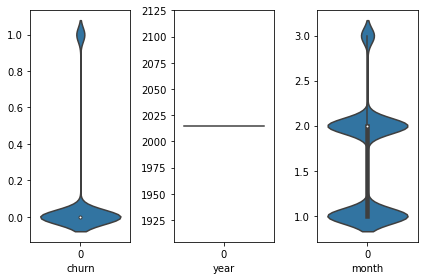

In [5]:
# visualisation of target metrics
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sb.violinplot(data=telco["churn"])
ax.set_xlabel("churn")

ax = fig.add_subplot(gs[0, 1])
sb.violinplot(data=telco["year"])
ax.set_xlabel("year")

ax = fig.add_subplot(gs[0, 2])
sb.violinplot(data=telco["month"])
ax.set_xlabel("month")

fig.tight_layout()

C:\Users\Mi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


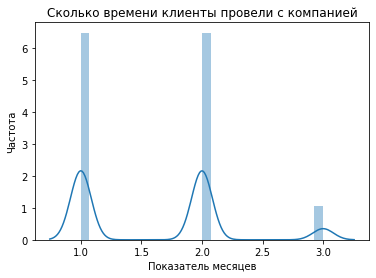

In [6]:
# customer lifetime
sb.distplot(telco.month)
plt.xlabel('Показатель месяцев')
plt.ylabel('Частота')
plt.title('Сколько времени клиенты провели с компанией')
plt.show()

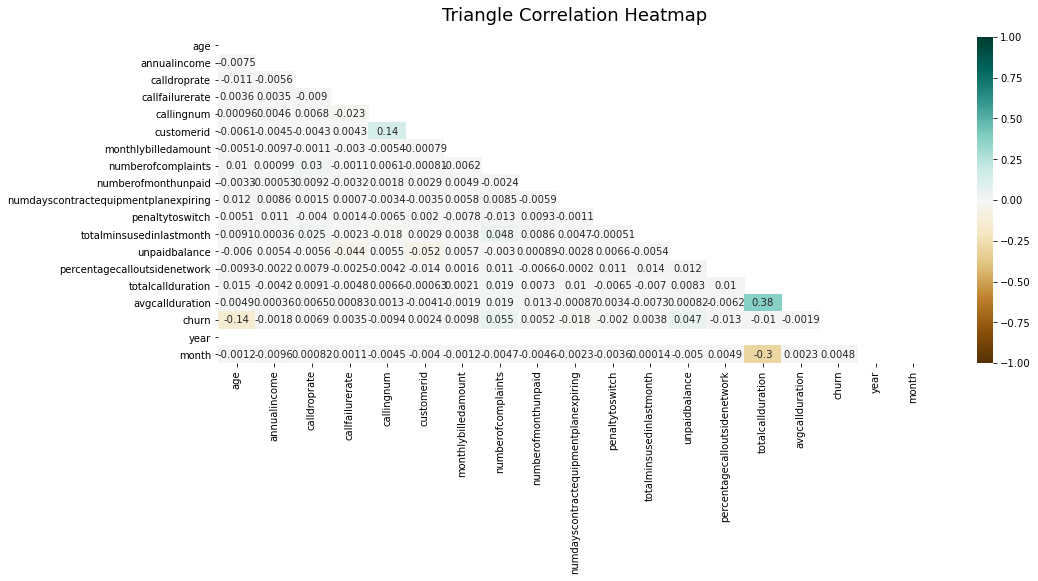

In [7]:
# create heatmap
plt.figure(figsize=(16, 6)) 

mask = np.triu(np.ones_like(telco.corr(), dtype=np.bool)) 
heatmap = sb.heatmap(telco.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [ ]:
surv = lf.WeibullAFTFitter()

surv.fit(df = telco, duration_col = 'month', event_col = 'churn', \
         formula = 'C(calldroprate)+C(callfailurerate)+C(customerid)+C(monthlybilledamount)+C(numberofcomplaints)+C(numberofmonthunpaid)+C(totalminsusedinlastmonth)+C(unpaidbalance)')

In [49]:
formula = ""
for i in ["C(" + x + ")" for x in cor[cor["churn"] > 0.001].churn.index]:
    formula += i + "+"
    
formula

'C(calldroprate)+C(callfailurerate)+C(customerid)+C(monthlybilledamount)+C(numberofcomplaints)+C(numberofmonthunpaid)+C(totalminsusedinlastmonth)+C(unpaidbalance)+C(churn)+C(month)+'

In [48]:
cor = telco.corr()
cor[cor["churn"] > 0.001].churn.index

Index(['calldroprate', 'callfailurerate', 'customerid', 'monthlybilledamount',
       'numberofcomplaints', 'numberofmonthunpaid', 'totalminsusedinlastmonth',
       'unpaidbalance', 'churn', 'month'],
      dtype='object')